<a href="https://colab.research.google.com/github/enliktjioe/master-thesis-2021/blob/main/Colab_SentimentAnalysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

- Tutorial source: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

# Let's Get Started

## Check NVIDIA GPU availability in Google Colab

In [3]:
!nvidia-smi

Mon Mar  1 23:51:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

In [4]:
# !pip install -q -U watermark

In [5]:
# !pip install -qq transformers

In [6]:
# !pip install torch==1.4.0 #try to match the version with tutorial PyTorch version

In [7]:
# !pip install transformers==2.8.0

In [8]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.4.0
transformers: 2.8.0



## Import Library

In [9]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

In [10]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 4.35MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 43.7MB/s]


In [11]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [12]:
df.shape

(15746, 11)

### Check missing values

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


No missing values found

### Check class imbalance

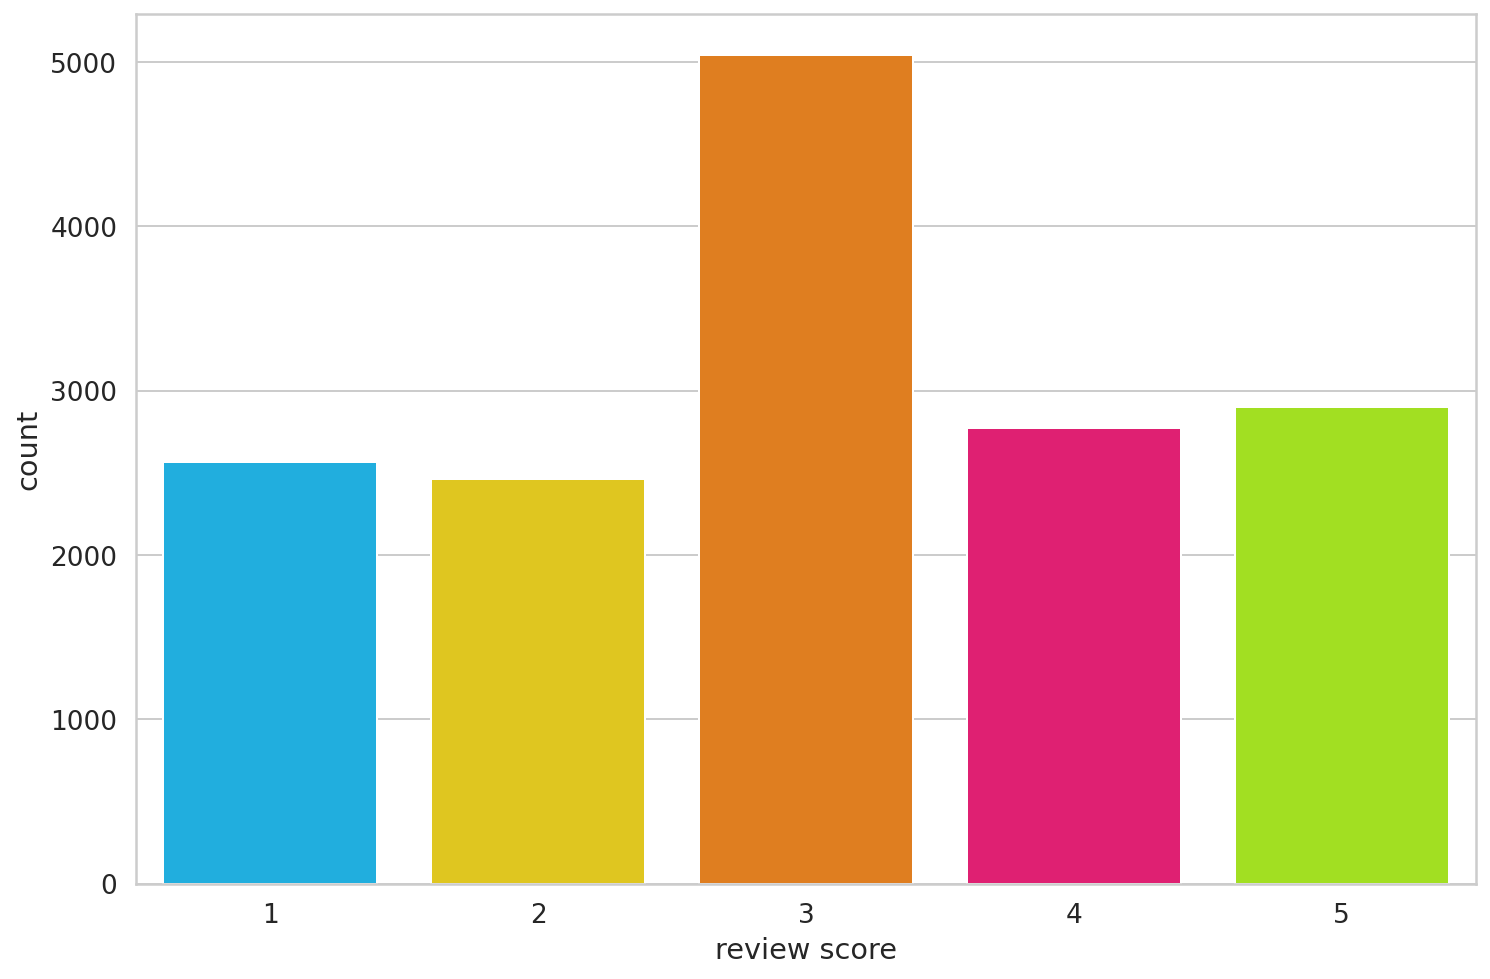

In [14]:
sns.countplot(df.score)
plt.xlabel('review score');

## Convert Into Negative, Neutral, and Positive Sentiment

In [15]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

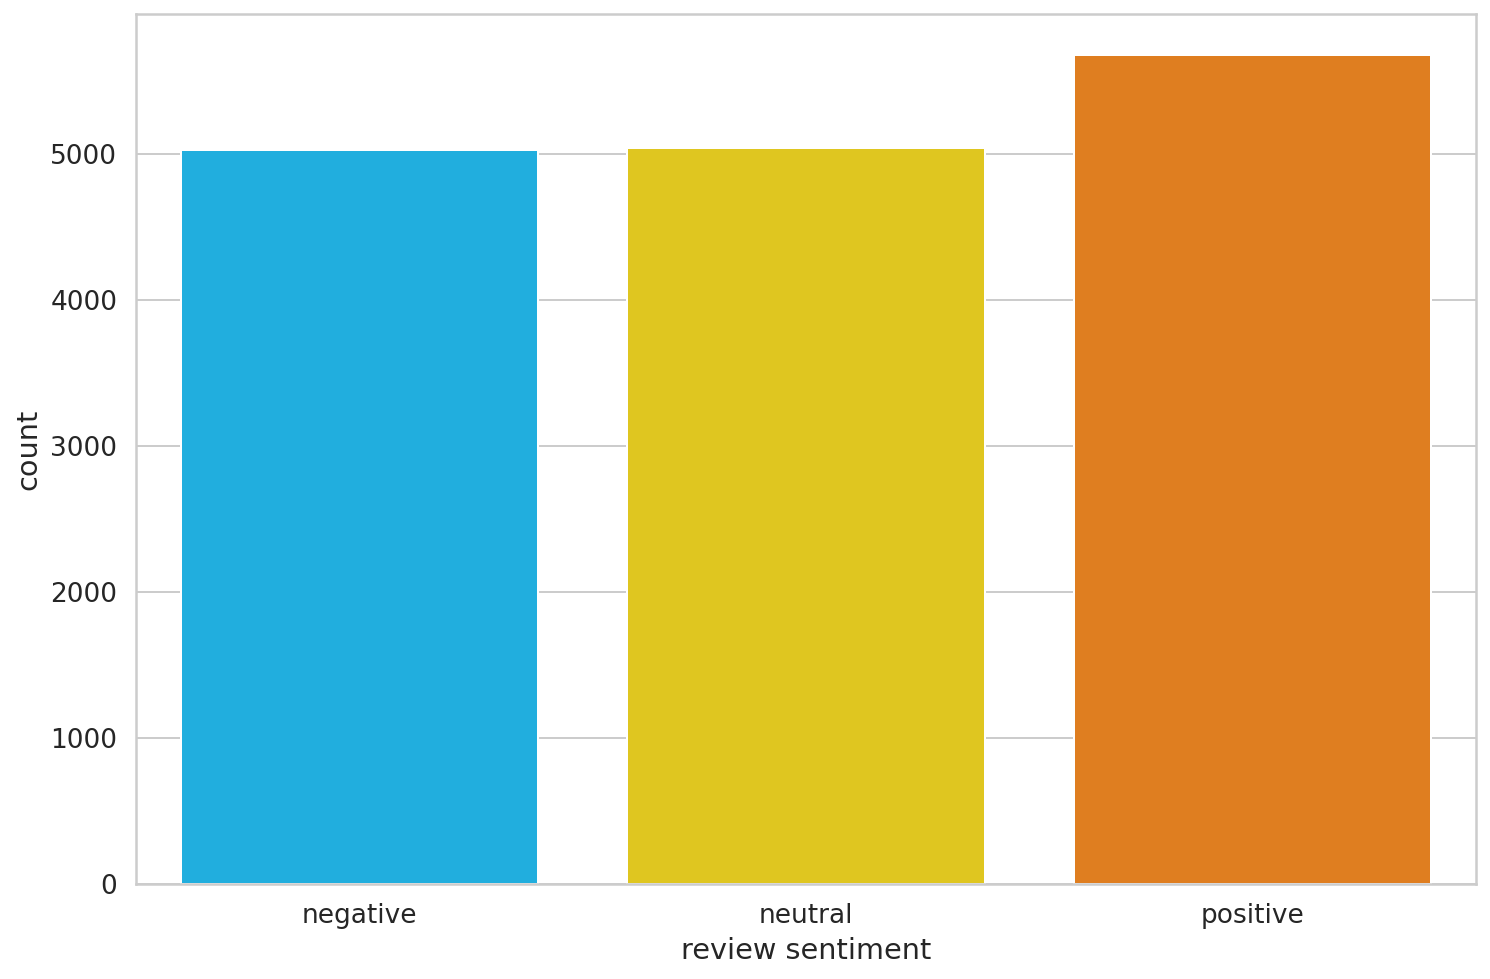

In [16]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

Now it's balanced

## Data Preprocessing

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Tokenization Example

In [19]:
sample_txt = '''
The restriction on the freedom of movement does not apply to passengers arriving from a country 
with an infection rate below 150 per 100 000 inhabitants in the past 14 days.
'''

In [20]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: 
The restriction on the freedom of movement does not apply to passengers arriving from a country 
with an infection rate below 150 per 100 000 inhabitants in the past 14 days.

   Tokens: ['The', 'restriction', 'on', 'the', 'freedom', 'of', 'movement', 'does', 'not', 'apply', 'to', 'passengers', 'arriving', 'from', 'a', 'country', 'with', 'an', 'infection', 'rate', 'below', '150', 'per', '100', '000', 'inhabitants', 'in', 'the', 'past', '14', 'days', '.']
Token IDs: [1109, 18760, 1113, 1103, 4438, 1104, 2230, 1674, 1136, 6058, 1106, 4861, 7190, 1121, 170, 1583, 1114, 1126, 8974, 2603, 2071, 4214, 1679, 1620, 1288, 4131, 1107, 1103, 1763, 1489, 1552, 119]


### Special Token

`[SEP]` - marker for ending of a **sentence**

In [21]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we’re doing classification

In [22]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

special token for padding

In [23]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token:

In [24]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the encode_plus() method:

In [25]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  1109, 18760,  1113,  1103,  4438,  1104,  2230,  1674,  1136,
         6058,  1106,  4861,  7190,  1121,   170,  1583,  1114,  1126,  8974,
         2603,  2071,  4214,  1679,  1620,  1288,  4131,  1107,  1103,  1763,
         1489,   102])

In [27]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

Inverse the tokenization to have a look at the special tokens

In [28]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'The',
 'restriction',
 'on',
 'the',
 'freedom',
 'of',
 'movement',
 'does',
 'not',
 'apply',
 'to',
 'passengers',
 'arriving',
 'from',
 'a',
 'country',
 'with',
 'an',
 'infection',
 'rate',
 'below',
 '150',
 'per',
 '100',
 '000',
 'inhabitants',
 'in',
 'the',
 'past',
 '14',
 '[SEP]']

## Choosing Sequence Length

In [29]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

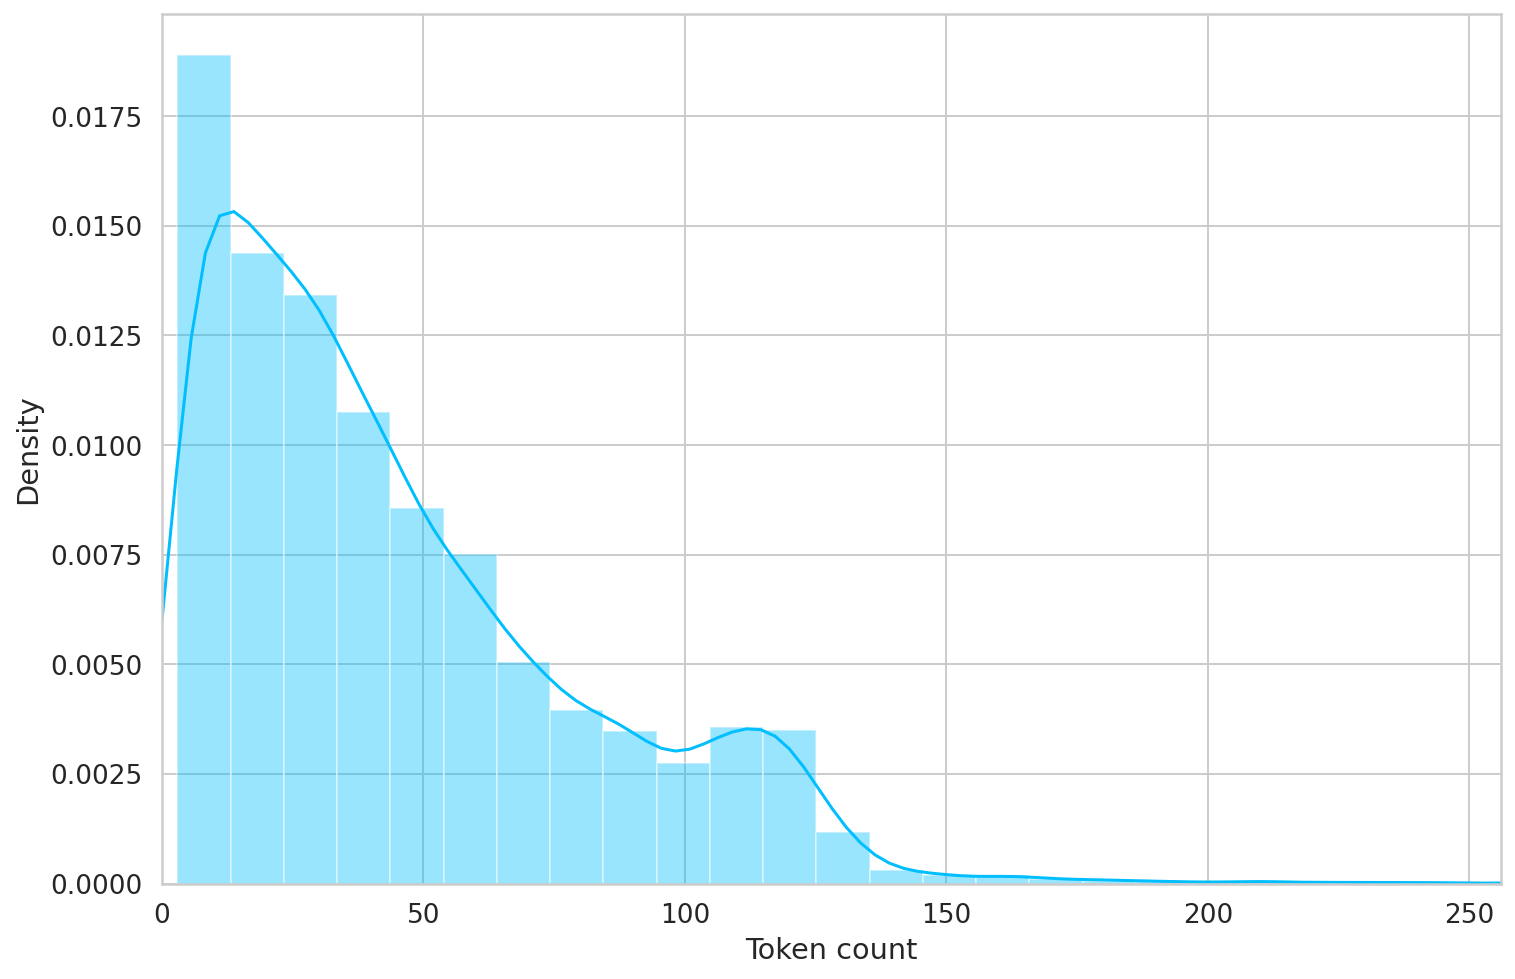

In [30]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Because most of the reviews contain less than 150 tokens, let's keep the max length = 160

In [31]:
MAX_LEN = 160

Building blocks required to crate a PyTorch dataset

In [32]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [33]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED

)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

### Create a couple of data loaders

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [35]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [36]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

Using the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build the sentiment classifier on top of this model

In [38]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [43]:
## newer Transformer version
# x = bert_model(
#   input_ids=encoding['input_ids'], 
#   attention_mask=encoding['attention_mask']
# )

# x

In [41]:
## newer Transformer version need this
# last_hidden_state = x['last_hidden_state']
# pooled_output = x['pooler_output']

In [44]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [45]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [46]:
bert_model.config.hidden_size

768

In [47]:
pooled_output.shape

torch.Size([1, 768])

### Classifier Function

In [48]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # pooled_output = x['pooler_output'] # for new Transformer version
    output = self.drop(pooled_output)
    return self.out(output)

### Create an instance and move it to GPU

In [49]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [50]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [51]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5879, 0.0842, 0.3279],
        [0.4308, 0.1888, 0.3804],
        [0.4871, 0.1766, 0.3363],
        [0.3364, 0.0778, 0.5858],
        [0.4025, 0.1040, 0.4935],
        [0.3599, 0.1026, 0.5374],
        [0.5054, 0.1552, 0.3394],
        [0.5962, 0.1464, 0.2574],
        [0.3274, 0.1967, 0.4759],
        [0.3026, 0.1118, 0.5856],
        [0.4103, 0.1571, 0.4326],
        [0.4879, 0.2121, 0.3000],
        [0.3811, 0.1477, 0.4712],
        [0.3354, 0.1354, 0.5292],
        [0.3999, 0.2822, 0.3179],
        [0.5075, 0.1684, 0.3242]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

In [52]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [54]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

#### 10 epochs required ~40mins

In [55]:
# %%time

# history = defaultdict(list)
# best_accuracy = 0

# for epoch in range(EPOCHS):

#   print(f'Epoch {epoch + 1}/{EPOCHS}')
#   print('-' * 10)

#   train_acc, train_loss = train_epoch(
#     model,
#     train_data_loader,    
#     loss_fn, 
#     optimizer, 
#     device, 
#     scheduler, 
#     len(df_train)
#   )

#   print(f'Train loss {train_loss} accuracy {train_acc}')

#   val_acc, val_loss = eval_model(
#     model,
#     val_data_loader,
#     loss_fn, 
#     device, 
#     len(df_val)
#   )

#   print(f'Val   loss {val_loss} accuracy {val_acc}')
#   print()

#   history['train_acc'].append(train_acc)
#   history['train_loss'].append(train_loss)
#   history['val_acc'].append(val_acc)
#   history['val_loss'].append(val_loss)

#   if val_acc > best_accuracy:
#     torch.save(model.state_dict(), 'best_model_state.bin')
#     best_accuracy = val_acc

In [56]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')

# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);

#### Download the pre-trained model

In [57]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

### Evaluation

In [58]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.883248730964467

In [62]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = nn.functional.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [63]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [64]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       245
     neutral       0.83      0.85      0.84       254
    positive       0.92      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



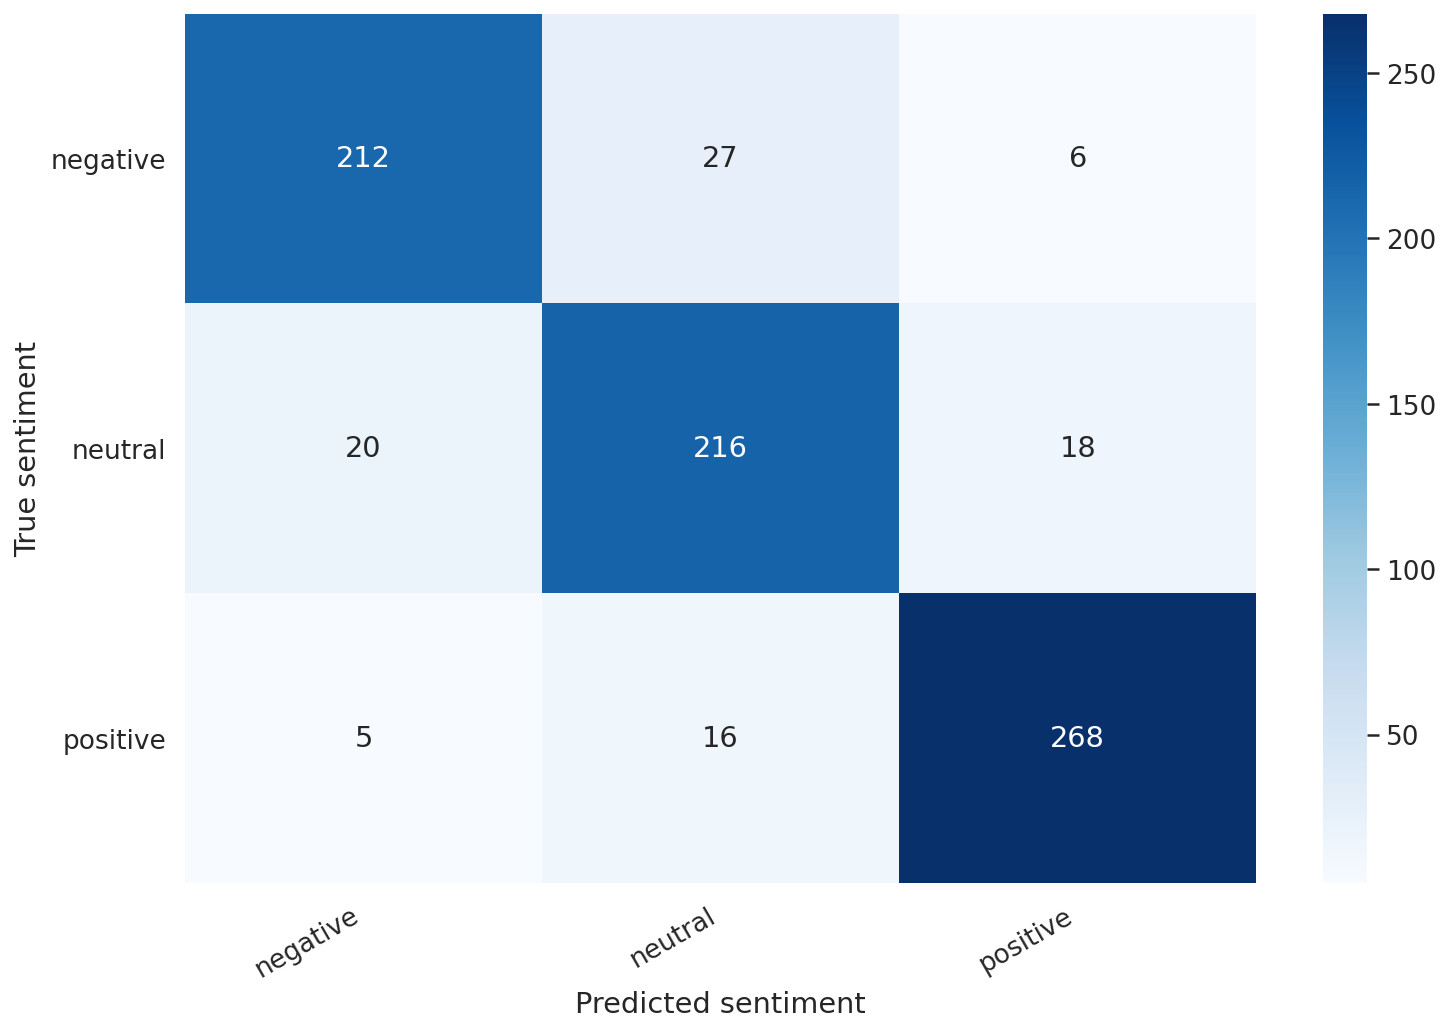

In [65]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [70]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [71]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


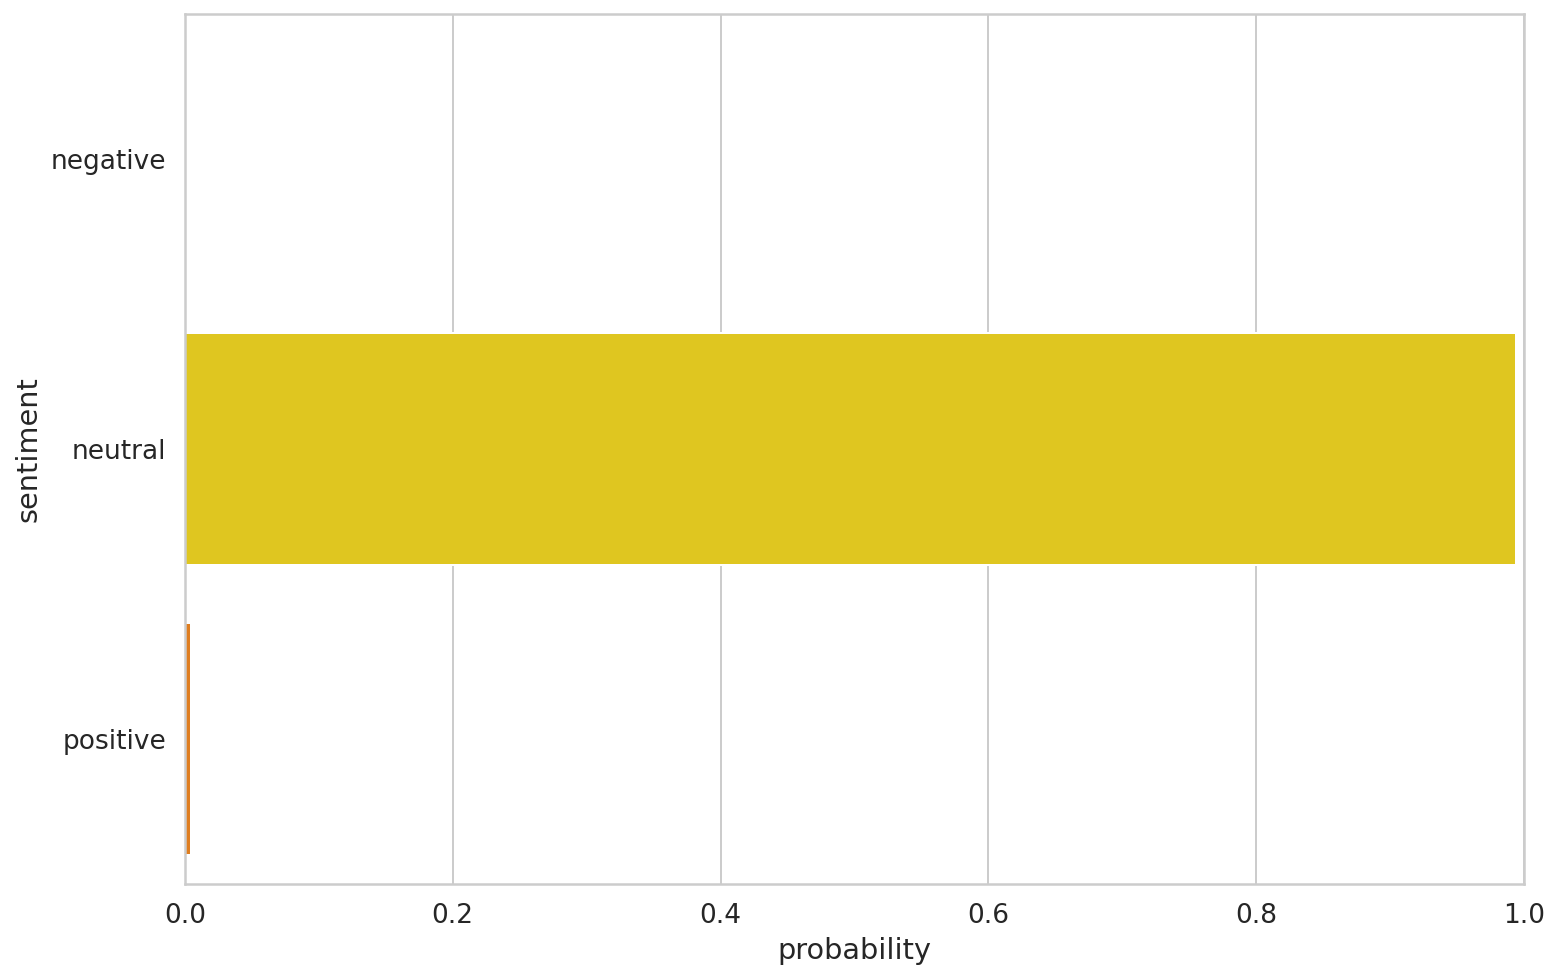

In [72]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

# Predicting on Raw Text

In [73]:
review_text = "I love completing my todos! Best app ever!!!"

In [74]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [75]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


# Predicting on Bolt Reviews

In [76]:
!gdown --id 1oUJU4T3NdvT6_ggEsUC73JWLF6_eXne9

Downloading...
From: https://drive.google.com/uc?id=1oUJU4T3NdvT6_ggEsUC73JWLF6_eXne9
To: /content/bolt_apple_appstore_review.csv
100% 853k/853k [00:00<00:00, 13.4MB/s]


In [79]:
bolt_apple = pd.read_csv('bolt_apple_appstore_review.csv', usecols=[3])
bolt_apple.head()

,review
0,I love bolt. I don’t use uber often because on...
1,So annoyed with this app!! Definitely the wors...
2,I’ve been using bolt for a month now. I had a ...
3,"To make things clear, I am not a regular revie..."
4,I have used the app 3 or 4 times and I thought...


In [81]:
bolt_apple['review'][0]

'I love bolt. I don’t use uber often because one ride even if it’s short is like £11. Whereas from my high street to my house is £3. Not only that but their drivers are SUPER friendly! I was sick one day (my first time using bolt) and the driver was so understanding and encouraged me throughout my journey. Bolt is 100% recommended by me. I don’t write reviews so that’s how you know I defiantly recommend it. My Instagram name is: TeeKezi if you wish to get in contact with me about bolt. I’m not an ambassador 😂 or anything like that. Just super happy with the service I have been receiving x'

In [85]:
review_index = 5

review_text = bolt_apple['review'][review_index]

In [86]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [87]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I’m so appalled at the attitude of the last driver I ordered from you. Three people recommended your services and I trusted those opinions. I’ve only taken four trips with Bolt and not ONE driver has worn a mask including the trips taken with my 7 month old baby. I ordered a XL car to help with moving a mirror and a bassinet to my destination, he took 15 minutes to get here, was on a call via loud speaker with a friend/family member. I asked if I could put my stuff into the boot as I was moving house and collecting the last items I had at my previous home. He declined and the person he was speaking to on the phone also got involved also. He then said it was my fault for ordering the wrong type of car, I told him I ordered the biggest car option on bolt. He said I would have to find another car and then told ME to cancel the drive. I refused so as he drove off he shouted something and left me, my baby and my things in the cold. Then to make matters worse, he cancelled the t

## 100 Reviews

In [89]:
# for review_index in range(0, len(bolt_apple)):
#   print(review_index)

In [91]:
for review_index in range(0, 99):
  review_text = bolt_apple['review'][review_index]

  encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  print(f'Review text: {review_text}')
  print(f'Sentiment  : {class_names[prediction]} \n')

Review text: I love bolt. I don’t use uber often because one ride even if it’s short is like £11. Whereas from my high street to my house is £3. Not only that but their drivers are SUPER friendly! I was sick one day (my first time using bolt) and the driver was so understanding and encouraged me throughout my journey. Bolt is 100% recommended by me. I don’t write reviews so that’s how you know I defiantly recommend it. My Instagram name is: TeeKezi if you wish to get in contact with me about bolt. I’m not an ambassador 😂 or anything like that. Just super happy with the service I have been receiving x
Sentiment  : neutral 

Review text: So annoyed with this app!! Definitely the worst of all of them. Sticking with Uber from now on. The driver arrival times are fake! It says the drivers have arrived when they are far away. Today the driver arrived and within a minute started driving away as if planning to do the route of my journey. I called customer support and was told that the driver w